In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from typing import Dict

from observational_fear.trajectories import TrajectoryVisulizer
from observational_fear.stats import auc, p_adjust
from typing import List, Tuple


import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
DATA_DIR = Path(r"F:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")
save_dir = DATA_DIR / "derived" / "tradjectories"

In [2]:
from matplotlib.colors import LinearSegmentedColormap

d2map = LinearSegmentedColormap.from_list("", ["#fff4cc","#806404"])
d4map = LinearSegmentedColormap.from_list("", ["#fbe5d7","#843c0c"])

start_map = LinearSegmentedColormap.from_list("", ["#f9e5e6","#c00000"])
stop_map = LinearSegmentedColormap.from_list("", ["#e2f0d9","#395723"])


In [3]:
class TrajectoryStats:
    def __init__(self, name, df_average_trace, df_null_trajectories, compare_col):
        self.name = name
        self.df_average_trace = df_average_trace
        self.df_null_trajectories = df_null_trajectories
        self.compare_col=compare_col
    
    @staticmethod
    def _prop_greater(observed_value, value_distrobution):
        return np.mean(np.abs(value_distrobution) > np.abs(observed_value)) * 2

    def get_trajectory_distance_time_series(self, component="both"):
        def _calculate_distance_p_values(obs, nulls):
            out = []
            for row in obs.itertuples():
                aligned = row.aligned
                obs_val = row.trajectory_distance
                null_vals = nulls[nulls.aligned == aligned]["trajectory_distance"]
                p = self._prop_greater(obs_val, null_vals)
                out.append((aligned, obs_val, p))
            df = pd.DataFrame(out, columns=["aligned", "trajectory_distance", "p"])
            df["p"] = p_adjust(df["p"])
            return df
        
        def _single_comp_diff(df):
            x = df[df[self.compare_col] == first][component].values[0]
            y = df[df[self.compare_col] == second][component].values[0]
            return abs(x - y)

        if component == "both":
            obs = self.df_average_trace[["aligned", "trajectory_distance"]].drop_duplicates()
            nulls = self.df_null_trajectories[["shuffle", "aligned", "trajectory_distance"]].drop_duplicates()
        else:
            first, second = self.df_null_trajectories[self.compare_col].unique()
            obs = self.df_average_trace.groupby("aligned", as_index=False).apply(_single_comp_diff,).rename(columns={None: "trajectory_distance"})
            nulls = self.df_null_trajectories.groupby(["aligned", "shuffle"], as_index=False).apply(_single_comp_diff,).rename(columns={None: "trajectory_distance"})
        obs = _calculate_distance_p_values(obs, nulls)
        return obs, nulls
    

    def calculate_distance_auc_p(self, obs, nulls, t_start, t_stop):
        obs_val = auc(obs.loc[lambda x: (x["aligned"] > t_start) & (x["aligned"] < t_stop)]["trajectory_distance"])
        null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x["aligned"] > t_start) & (x["aligned"] < t_stop)]["trajectory_distance"]))
        p = self._prop_greater(obs_val, null_vals)
        return obs_val, null_vals, p
    
    def calculate_distance_auc_p_range(self, obs, nulls, t_start_stops: List[Tuple[float, float]]):
        out = []
        for t_start, t_stop in t_start_stops:
            obs_val, null_vals, p = self.calculate_distance_auc_p(obs, nulls, t_start=t_start, t_stop=t_stop)
            null_mean = np.mean(null_vals)
            null_se = np.std(null_vals) / np.sqrt(len(null_vals))
            out.append((t_start, t_stop, obs_val, p, null_mean, null_se))

        df = pd.DataFrame(out, columns=["Interval Start", "Interval Stop", "Observed AUC", "p", "Null AUC [Mean]", "Null AUC [SE]"])
        df["p"] = p_adjust(df["p"])
        return df



In [4]:
class TrajectoryPlotter:
    def __init__(self, name, compare_col: str, cmaps, default_time_label="Time Relative to Event"):
        self.vis = TrajectoryVisulizer(name=name)
        self.cmaps = cmaps
        self.default_time_label = default_time_label
        self.compare_col = compare_col

    
    @staticmethod
    def _get_ax(ax):
        if ax is None:
            _, ax = plt.subplots()
        return ax

    def plot_trajectory_scatter(self, df_average_trajectories, ax=None):
        ax = self._get_ax(ax)
        ax = self.vis.plot_trajectories_pc_space_2d(df_average_trajectories, compare_col=self.compare_col, cmaps=self.cmaps, ax=ax, markers=["o", "o"])
        at_0 = df_average_trajectories.loc[lambda x: x["aligned"] == 0]
        ax.scatter(x=at_0["PC1"], y=at_0["PC2"], s=70, marker="+", color="black")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        return ax
    
    def plot_single_pc_trajectory(self, df_average_trajectories, component, ax=None):
        ax = self._get_ax(ax)
        first, second = df_average_trajectories[self.compare_col].unique()

        df_average_trajectories[df_average_trajectories[self.compare_col] == first].plot(x="aligned", y=component, ax=ax, label=first)
        df_average_trajectories[df_average_trajectories[self.compare_col] == second].plot(x="aligned", y=component, ax=ax, label=second)
        ax.set_ylabel(component)
        ax.set_xlabel(self.default_time_label)
        return ax

    def plot_statespace(self, df_average_trajectories, component, ax=None):
        if component == "both":
            return self.plot_trajectory_scatter(df_average_trajectories, ax=ax)
        else:
            return self.plot_single_pc_trajectory(df_average_trajectories, component=component, ax=ax)

    
    def plot_trajectory_distance_ts(self, obs, nulls, include_sig_pvals=True, ax=None,):
        ax = self._get_ax(ax)
        obs.plot(x="aligned", y="trajectory_distance", color="black", ax=ax)
        sns.lineplot(data=nulls, x="aligned", y="trajectory_distance", color="grey", ax=ax)
        ax.set_ylabel("Distance Between Trajectories")
        ax.set_xlabel("Time Relative to Event")
        if include_sig_pvals:
            sigs_xs = obs.loc[lambda x: x.p < 0.05]["aligned"].values
            sigs_ys = np.ones(len(sigs_xs)) * obs["trajectory_distance"].max() + obs["trajectory_distance"].std()
            ax.scatter(x=sigs_xs, y=sigs_ys, color="black")
        return ax


    def plot_null_auc(self, obs_val, null_vals, ax=None):
        ax = self._get_ax(ax)
        sns.histplot(x=null_vals, color="black", ax=ax)
        ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}")
        plt.legend()
        plt.xlabel("Null Trajectory Distance AUC")
        plt.title("Distrobution of Null Divergences")
        return ax


In [5]:
class Runner:

    def __init__(self, name, data_dir, save_dir, compare_col, cmaps, save_figs=False, save_data=False, AUC_intervals=None):
        self.data = self.load_data(data_dir, name)
        self.name=name
        self.compare_col = compare_col
        self.visulizer = TrajectoryPlotter(name=name, compare_col=compare_col, cmaps=cmaps)
        self.stats = TrajectoryStats(name=name, df_average_trace=self.data["avg"], df_null_trajectories=self.data["nulls"], compare_col=compare_col)
        
        if AUC_intervals is None:
            AUC_intervals = (
                (-10, 10),
                (-10, 0),
                (-5, 0),
                (-2.5, 2.5),
                (0, 10),
            )
        self.AUC_intervals = AUC_intervals
        
        self.save_dir = save_dir / self.name
        self.save_dir.mkdir(exist_ok=True, parents=True)
        self.save_figs=save_figs
        self.save_data = save_data


    def _savefig(self, plot_name, ext="svg"):
        if self.save_figs:
            plt.savefig(self.save_dir / f"Trajectories - {self.name} - {plot_name}.{ext}")

    def _run_single(self, component):
        trajectory_distance = dict()
        trajectory_distance["obs"], trajectory_distance["nulls"] = self.stats.get_trajectory_distance_time_series(component)
        self.visulizer.plot_statespace(self.data["avg"], component=component)
        self._savefig(f"{component}  - Trajectory Time Series")
        self.visulizer.plot_trajectory_distance_ts(trajectory_distance["obs"], trajectory_distance["nulls"])
        self._savefig(f"{component} - Trajectory Distance Time Series")
        auc_pvals = self.stats.calculate_distance_auc_p_range(trajectory_distance["obs"], trajectory_distance["nulls"], self.AUC_intervals)
        for t_start, t_stop in self.AUC_intervals:
            obs_val, null_vals, _ = self.stats.calculate_distance_auc_p(obs=trajectory_distance["obs"], nulls=trajectory_distance["nulls"], t_start=t_start, t_stop=t_stop)
            self.visulizer.plot_null_auc(obs_val, null_vals)
            self._savefig(f"{component}  - Null Distance AUC - Start={t_start} Stop={t_stop}")
        self.save_csv(trajectory_distance["obs"], data_name=f"{component}  Observed Trajectory Distances")
        self.save_csv(trajectory_distance["nulls"], data_name=f"{component}  - Null Trajectory Distances")
        self.save_csv(auc_pvals, data_name=f"{component}  - Distance AUC P Values")

    def run(self):
        self._run_single(component="both")
        self._run_single(component="PC1")
        self._run_single(component="PC2")


    @staticmethod
    def load_data(data_dir, name) -> Dict:
        out  = {}
        out["nulls"] = pd.read_parquet(data_dir / f"Null Trajectories - {name}.parquet.gzip")
        out["scree"] = pd.read_csv(data_dir / f"Trajectories - {name} - Scree.csv")
        out["loadings"] = pd.read_csv(data_dir / f"Trajectories - {name} - Loadings.csv")
        out["avg"] = pd.read_csv(data_dir / f"Trajectories - {name} - Average Trajectory TimeSeries.csv")
        out["trajectories"] = pd.read_csv(data_dir / f"Trajectories - {name} - Trajectory TimeSeries.csv")
        return out
    
    def save_csv(self, df, data_name, index=False):
        if self.save_data:
            df.to_csv(self.save_dir / f"Trajectories - {self.name} - {data_name}.csv", index=index)

In [ ]:
runner = Runner(
    name="Freeze Start Stop", 
    compare_col="start_stop", 
    cmaps=(start_map, stop_map), 
    data_dir=save_dir, 
    save_dir=save_dir,
    save_data=True,
    save_figs=True
    )

runner.run()

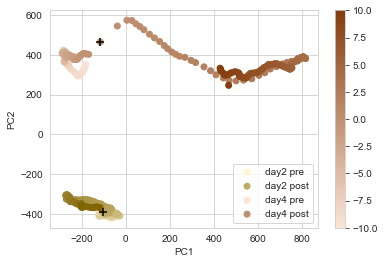

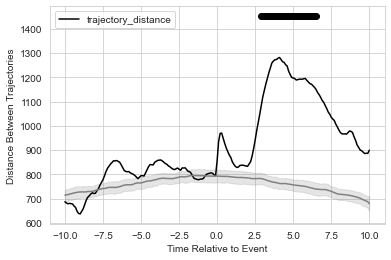

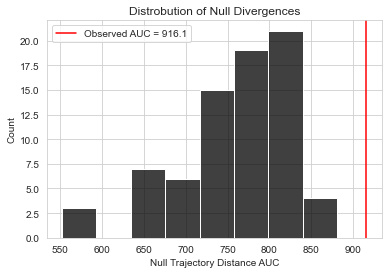

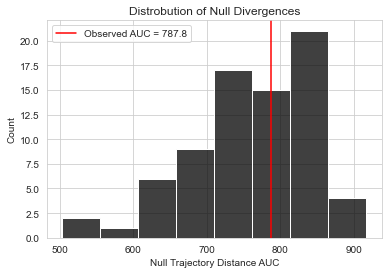

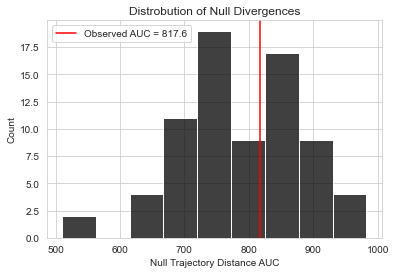

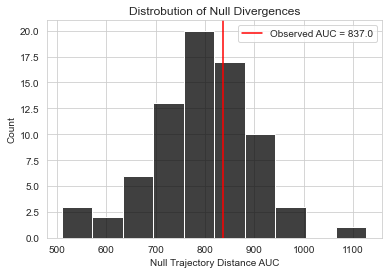

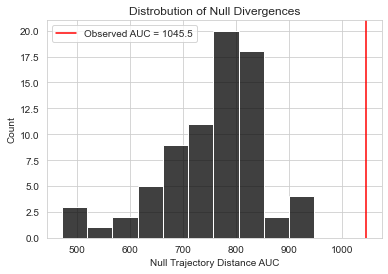

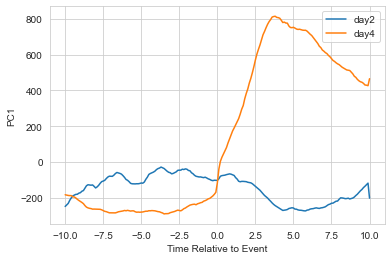

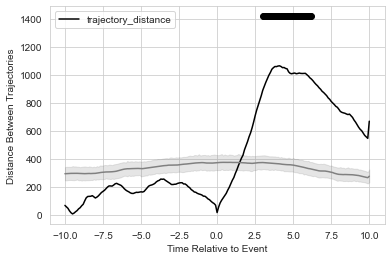

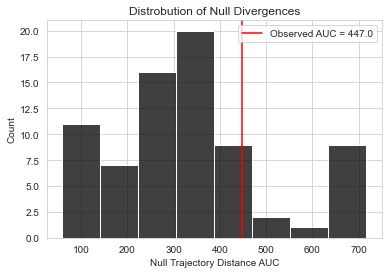

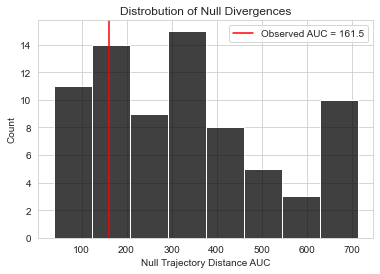

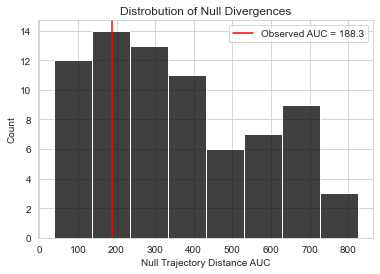

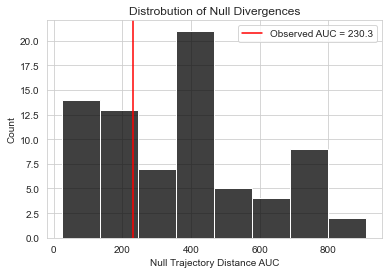

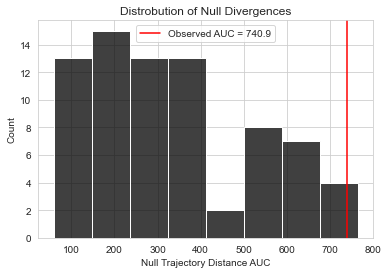

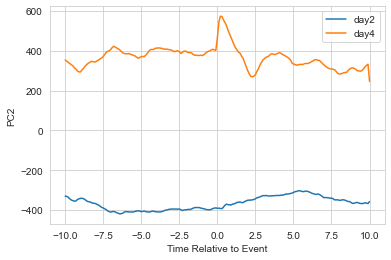

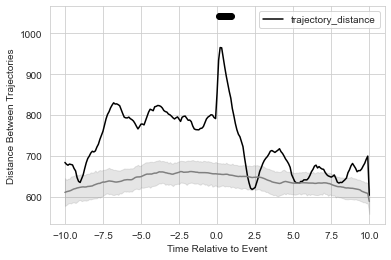

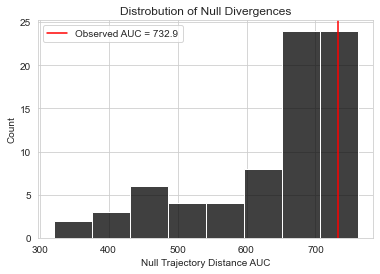

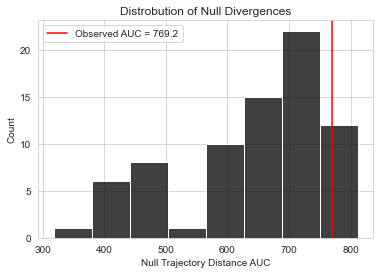

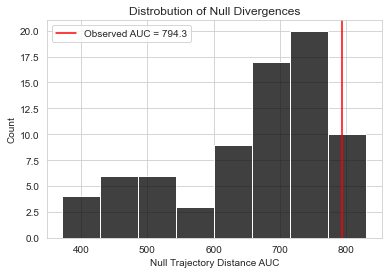

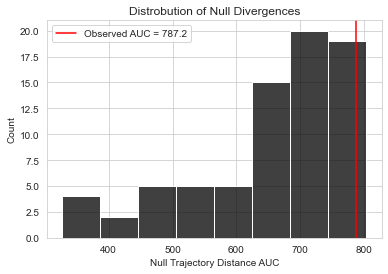

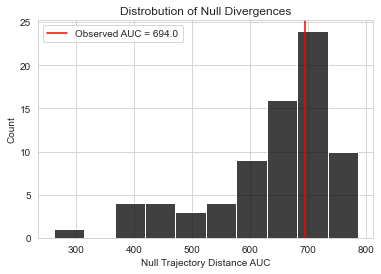

In [7]:
runner = Runner(
    name="US Combined", 
    compare_col="session", 
    cmaps=(d2map, d4map), 
    data_dir=save_dir, 
    save_dir=save_dir,
    save_data=True,
    save_figs=True
    )

runner.run()

In [ ]:
def prop_greater(val, dist):
    return np.mean(np.abs(dist) > np.abs(val)) * 2

In [ ]:
name = "Freeze Start Stop"
data = load_data(data_dir=save_dir, name=name)

stats = TrajectoryStats(name=name, data=data)

obs, nulls = stats.get_trajectory_distance_time_series()

start_stops = (
    (-10, 10),
    (-10, 0),
    (-5, 0),
    (-2.5, 2.5),
    (0, 10),
)
df_res = stats.calculate_distance_auc_p_range(obs, nulls, start_stops)

In [ ]:
df_res

In [ ]:
from observational_fear.stats import p_adjust


out = []
for row in obs.itertuples():
    aligned = row.aligned
    obs_val = row.trajectory_distance
    null_vals = nulls[nulls.aligned == aligned]["trajectory_distance"]
    p = prop_greater(obs_val, null_vals)
    out.append((aligned, obs_val, p))

df_res = pd.DataFrame(out, columns=["aligned", "observed_distance", "p"])
df_res["p"] = p_adjust(df_res["p"])

In [ ]:
df_res.plot(x="aligned", y="p")

In [ ]:
# _, ax = plt.subplots(ncols=3, figsize=(15, 4))

_, ax = plt.subplots()

name = "Freeze Start Stop"
data = load_data(data_dir=save_dir, name=name)
vis = TrajectoryVisulizer("Freeze Start Stop")
vis.plot_trajectories_pc_space_2d(data["avg"], compare_col="start_stop", cmaps=[start_map, stop_map], ax=ax, markers=["o", "o"])
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.savefig(save_dir / "State Space Freeze Start Stop.svg")


_, ax = plt.subplots()
obs = data["avg"][["aligned", "trajectory_distance"]].drop_duplicates()
nulls = data["nulls"][["shuffle", "aligned", "trajectory_distance"]].drop_duplicates()
obs.plot(x="aligned", y="trajectory_distance", color="black", ax=ax)
sns.lineplot(data=nulls, x="aligned", y="trajectory_distance", color="grey", ax=ax)
ax.set_ylabel("Distance Between Trajectories")
ax.set_xlabel("Time Relative to Behaviour")


_, ax = plt.subplots()
obs_val = auc(obs.loc[lambda x: (x.aligned > -5) & (x.aligned < 0)]["trajectory_distance"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x.aligned > -5) & (x.aligned < 0)]["trajectory_distance"]))
sns.histplot(x=null_vals, color="black", ax=ax)
ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.legend()
plt.xlabel("Trajectory Distance (Start v Stop) AUC [-5 -> 0]")
plt.title("Distrobution of Null Divergences")



In [ ]:
def startstop_diff(x, pc):
    start = x.loc[lambda x: x.start_stop == "start"][pc].values[0]
    stop = x.loc[lambda x: x.start_stop == "stop"][pc].values[0]
    return abs(start - stop)

# PC1


nulls = data["nulls"].groupby(["aligned", "shuffle"], as_index=False).apply(startstop_diff, pc="PC1").rename(columns={None: "diff"})
obs = data["avg"].groupby("aligned", as_index=False).apply(startstop_diff, pc="PC1").rename(columns={None: "diff"})


_, ax = plt.subplots()
data["avg"].loc[lambda x: x.start_stop == "start"].plot(x="aligned", y="PC1", ax=ax, label="start")
data["avg"].loc[lambda x: x.start_stop == "stop"].plot(x="aligned", y="PC1", ax=ax, label="stop")
ax.set_title("Trajectories")
ax.set_ylabel("PC1")
ax.set_xlabel("Time Relative to Freeze")
plt.savefig(save_dir / "State Space Freeze Start Stop PC1.svg")



_, ax = plt.subplots()
obs.plot(x="aligned", y="diff", color="black", ax=ax)
sns.lineplot(data=nulls, x="aligned", y="diff", color="grey", ax=ax)
ax.set_ylabel("Distance Between Behavior PC1s")


_, ax = plt.subplots()
obs_val = auc(obs.loc[lambda x: (x.aligned > -5) & (x.aligned < 0)]["diff"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x["aligned"] > -5) & (x["aligned"] < 0)]["diff"]))
sns.histplot(x=null_vals, color="black", ax=ax)
ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.xlabel("Trajectory Distance (Start v Stop) AUC [-5 -> 0]")
plt.legend()
nulls = data["nulls"].groupby(["aligned", "shuffle"], as_index=False).apply(startstop_diff, pc="PC2").rename(columns={None: "diff"})
obs = data["avg"].groupby("aligned", as_index=False).apply(startstop_diff, pc="PC2").rename(columns={None: "diff"})
plt.title("Distrobution of Null Divergences")


In [ ]:
# PC2

_, ax = plt.subplots()
data["avg"].loc[lambda x: x.start_stop == "start"].plot(x="aligned", y="PC2", ax=ax, label="start")
data["avg"].loc[lambda x: x.start_stop == "stop"].plot(x="aligned", y="PC2", ax=ax, label="stop")
ax.set_title("Trajectories")
ax.set_ylabel("PC2")
ax.set_xlabel("Time Relative to Freeze")
plt.savefig(save_dir / "Freeze Start Stop - PC2 - State Space.svg")


_, ax = plt.subplots()
obs.plot(x="aligned", y="diff", color="black", ax=ax)
sns.lineplot(data=nulls, x="aligned", y="diff", color="grey", ax=ax)
ax.set_ylabel("Distance Between Behavior PC2s")



_, ax = plt.subplots()
obs_val = auc(obs.loc[lambda x: (x.aligned > -5) & (x.aligned < 0)]["diff"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x["aligned"] > -5) & (x["aligned"] < 0)]["diff"]))
sns.histplot(x=null_vals, color="black", ax=ax)
ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.legend()
plt.xlabel("Trajectory Distance (Start v Stop) AUC [-5 -> 0]")
plt.title("Distrobution of Null Divergences")


In [ ]:
# USD2 USD4

_, ax = plt.subplots()
name = "US Combined"
data = load_data(data_dir=save_dir, name=name)
vis = TrajectoryVisulizer(name)
vis.plot_trajectories_pc_space_2d(data["avg"], compare_col="session", cmaps=[d2map, d4map], ax=ax, markers=["o", "o"])
ax.set_ylabel("PC2")
ax.set_xlabel("PC1")
plt.savefig(save_dir / "State Space USD2 USD4.svg")


_, ax = plt.subplots()
obs = data["avg"][["aligned", "trajectory_distance"]].drop_duplicates()
nulls = data["nulls"][["shuffle", "aligned", "trajectory_distance"]].drop_duplicates()
obs.plot(x="aligned", y="trajectory_distance", color="black", ax=ax)
sns.lineplot(data=nulls, x="aligned", y="trajectory_distance", color="grey", ax=ax)
ax.set_ylabel("Distance Between Trajectories")
ax.set_xlabel("Time Relative to Behaviour")
ax.set_title("Distance Between Trajectories")


_, ax = plt.subplots()
obs_val = auc(obs.loc[lambda x: (x.aligned > 0)]["trajectory_distance"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x.aligned > 0)]["trajectory_distance"]))
sns.histplot(x=null_vals, color="black", ax=ax)
ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.legend()
plt.xlabel("Trajectory Distance (D2 v D4) AUC [post period]")
plt.title("Distrobution of Null Divergences")

In [ ]:
def session_diff(x, pc):
    start = x.loc[lambda x: x.session == "day2"][pc].values[0]
    stop = x.loc[lambda x: x.session == "day4"][pc].values[0]
    return abs(start - stop)


# PC1

_, ax = plt.subplots()
nulls = data["nulls"].groupby(["aligned", "shuffle"], as_index=False).apply(session_diff, pc="PC1").rename(columns={None: "diff"})
obs = data["avg"].groupby("aligned", as_index=False).apply(session_diff, pc="PC1").rename(columns={None: "diff"})
data["avg"].loc[lambda x: x.session == "day2"].plot(x="aligned", y="PC1", ax=ax, label="day2")
data["avg"].loc[lambda x: x.session == "day4"].plot(x="aligned", y="PC1", ax=ax, label="day4")
ax.set_title("Trajectories")
ax.set_ylabel("PC1")
plt.savefig(save_dir / "State Space USD2 USD4 PC1.svg")



_, ax = plt.subplots()
obs.plot(x="aligned", y="diff", color="black", ax=ax)
sns.lineplot(data=nulls, x="aligned", y="diff", color="grey", ax=ax)
ax.set_ylabel("Distance Between PC1s")
ax.set_xlabel("Time Relative to Behaviour")
ax.set_title("Distance Between Trajectories")


_, ax = plt.subplots()
obs_val = auc(obs.loc[lambda x: (x.aligned > 0)]["diff"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x.aligned > 0)]["diff"]))
sns.histplot(x=null_vals, color="black", ax=ax)
ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.legend()
plt.xlabel("Trajectory Distance (D2 v D4) AUC [post period]")
plt.title("Distrobution of Null Divergences")


In [ ]:
# PC2
_, ax = plt.subplots()

nulls = data["nulls"].groupby(["aligned", "shuffle"], as_index=False).apply(session_diff, pc="PC2").rename(columns={None: "diff"})
obs = data["avg"].groupby("aligned", as_index=False).apply(session_diff, pc="PC2").rename(columns={None: "diff"})
data["avg"].loc[lambda x: x.session == "day2"].plot(x="aligned", y="PC2", ax=ax, label="day2")
data["avg"].loc[lambda x: x.session == "day4"].plot(x="aligned", y="PC2", ax=ax, label="day4")
ax.set_title("Trajectories")
ax.set_ylabel("PC2")
plt.savefig(save_dir / "State Space USD2 USD4 PC2.svg")



_, ax = plt.subplots()
obs.plot(x="aligned", y="diff", color="black", ax=ax)
sns.lineplot(data=nulls, x="aligned", y="diff", color="grey", ax=ax)
ax.set_ylabel("Distance Between PC2s")
ax.set_xlabel("Time Relative to Behaviour")
ax.set_title("Distance Between Trajectories")

_, ax = plt.subplots()
obs_val = auc(obs.loc[lambda x: (x.aligned > 0)]["diff"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x.aligned > 0)]["diff"]))
sns.histplot(x=null_vals, color="black", ax=ax)
ax.axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.legend()
plt.xlabel("Trajectory Distance (D2 v D4) AUC [post period]")
plt.title("Distrobution of Null Divergences")


In [ ]:
name = "US Combined"
data = load_data(data_dir=save_dir, name=name)

In [ ]:
obs = data["avg"][["aligned", "trajectory_distance"]].drop_duplicates()

nulls = data["nulls"][["shuffle", "aligned", "trajectory_distance"]].drop_duplicates()

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(10, 4))
obs.plot(x="aligned", y="trajectory_distance", color="black", ax=ax[0])
sns.lineplot(data=nulls, x="aligned", y="trajectory_distance", color="grey", ax=ax[0])


obs_val = auc(obs.loc[lambda x: (x.aligned > 0)]["trajectory_distance"])
null_vals = nulls.groupby("shuffle").apply(lambda x: auc(x.loc[(x.aligned > 0)]["trajectory_distance"]))
sns.histplot(x=null_vals, color="black", ax=ax[1])
ax[1].axvline(obs_val, color="red", label=f"Observed AUC = {obs_val:.1f}\np = {(null_vals>=obs_val).mean():2f}")
plt.legend()